In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Loading, cleaning and initial EDA

In [89]:
df = pd.read_csv("C:\\Users\\Utente\\Documents\\PythonV\\datasets\\used_car_price_dataset_extended.csv")

df

,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,brand,transmission,color,service_history,accidents_reported,insurance_valid
0,2001,8.17,4000,Petrol,4,8587.64,Chevrolet,Manual,White,NaN,0,No
1,2014,17.59,1500,Petrol,4,5943.50,Honda,Manual,Black,NaN,0,Yes
2,2023,18.09,2500,Diesel,5,9273.58,BMW,Automatic,Black,Full,1,Yes
3,2009,11.28,800,Petrol,1,6836.24,Hyundai,Manual,Blue,Full,0,Yes
4,2005,12.23,1000,Petrol,2,4625.79,Nissan,Automatic,Red,Full,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1996,15.25,1500,Petrol,2,5498.71,Hyundai,Manual,Silver,NaN,0,Yes
9996,1997,14.45,5000,Diesel,1,9588.31,Honda,Manual,Gray,Full,0,Yes
9997,2002,19.41,1000,Diesel,4,4557.10,Kia,Manual,Black,Full,0,Yes
9998,2005,12.95,4000,Petrol,5,7413.59,BMW,Automatic,Blue,Full,0,Yes


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make_year           10000 non-null  int64  
 1   mileage_kmpl        10000 non-null  float64
 2   engine_cc           10000 non-null  int64  
 3   fuel_type           10000 non-null  object 
 4   owner_count         10000 non-null  int64  
 5   price_usd           10000 non-null  float64
 6   brand               10000 non-null  object 
 7   transmission        10000 non-null  object 
 8   color               10000 non-null  object 
 9   service_history     7962 non-null   object 
 10  accidents_reported  10000 non-null  int64  
 11  insurance_valid     10000 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 937.6+ KB


In [91]:
df["accidents_reported"].value_counts()
# we are gonna clip the outliers so that 4 and 5 still fall into the 3 category; it's not that accurate, but the number of samples is too low 
# so it's not a big deal



accidents_reported
0    6081
1    3058
2     731
3     120
4       8
5       2
Name: count, dtype: int64

In [92]:
df['accidents'] = df['accidents_reported'].clip(upper=3)
df.drop(columns=['accidents_reported'], inplace=True)

df["accidents"].value_counts()



accidents
0    6081
1    3058
2     731
3     130
Name: count, dtype: int64

In [93]:
df["service_history"].value_counts()

service_history
Full       4987
Partial    2975
Name: count, dtype: int64

In [94]:
df['service_history'] = df['service_history'].fillna('Unknown')
# in this case, we can fill NaN with 'Unknown' to avoid losing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   make_year        10000 non-null  int64  
 1   mileage_kmpl     10000 non-null  float64
 2   engine_cc        10000 non-null  int64  
 3   fuel_type        10000 non-null  object 
 4   owner_count      10000 non-null  int64  
 5   price_usd        10000 non-null  float64
 6   brand            10000 non-null  object 
 7   transmission     10000 non-null  object 
 8   color            10000 non-null  object 
 9   service_history  10000 non-null  object 
 10  insurance_valid  10000 non-null  object 
 11  accidents        10000 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 937.6+ KB


In [95]:
df['service_history'].value_counts()

service_history
Full       4987
Partial    2975
Unknown    2038
Name: count, dtype: int64

In [96]:
df['car_age'] = 2025 - df['make_year']

df.drop(columns=['make_year'], inplace=True)



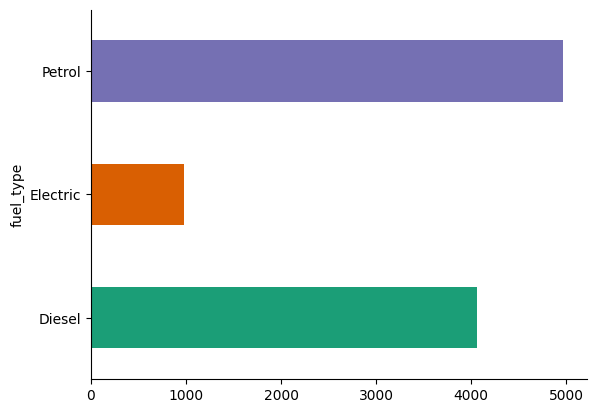

In [97]:
# @title fuel_type

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('fuel_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

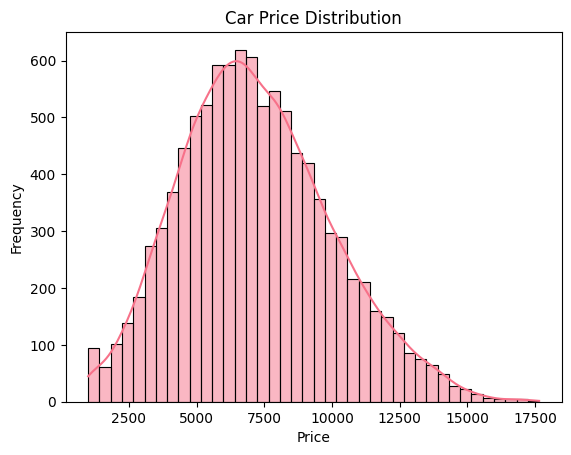

In [98]:
sns.histplot(df['price_usd'], bins=40, kde=True)
plt.title("Car Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

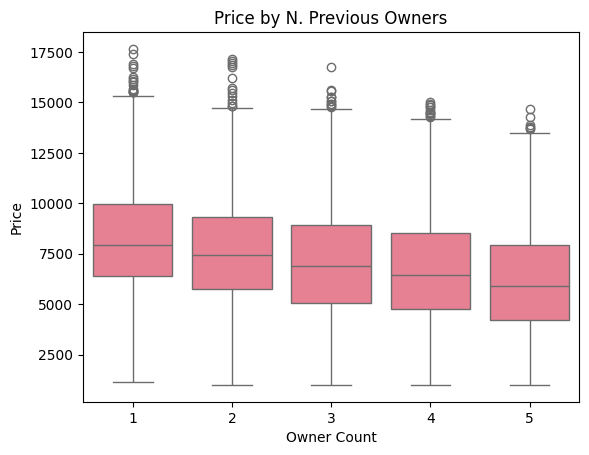

In [99]:
sns.boxplot(data=df, x='owner_count', y='price_usd')
plt.title("Price by N. Previous Owners")
plt.xlabel("Owner Count")
plt.ylabel("Price")
plt.show()

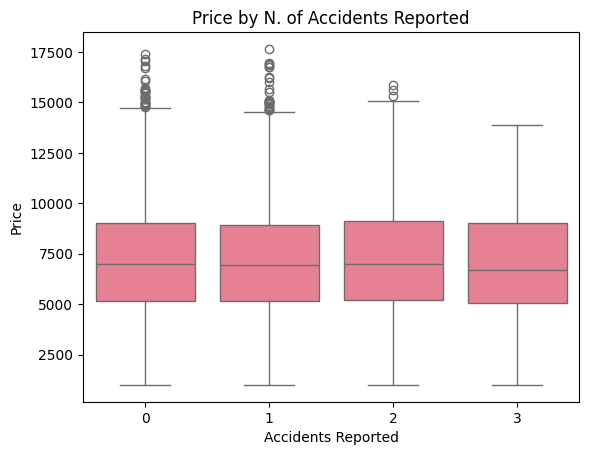

In [100]:
sns.boxplot(data=df, x='accidents', y='price_usd')
plt.title("Price by N. of Accidents Reported")
plt.xlabel("Accidents Reported")
plt.ylabel("Price")
plt.show()

# Preprocessing

In [101]:
# train/test split

X = df.drop(["price_usd"], axis = 1)
y = df["price_usd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [102]:
X_test

,mileage_kmpl,engine_cc,fuel_type,owner_count,brand,transmission,color,service_history,insurance_valid,accidents,car_age
6252,12.09,5000,Diesel,1,Nissan,Automatic,White,Full,No,2,10
4684,14.03,800,Petrol,4,Chevrolet,Manual,White,Partial,Yes,0,9
1731,20.40,2000,Petrol,1,Kia,Manual,Blue,Full,Yes,2,20
4742,25.09,800,Diesel,3,Volkswagen,Manual,Silver,Full,Yes,0,29
4521,19.25,5000,Diesel,5,Hyundai,Automatic,Black,Partial,No,0,30
...,...,...,...,...,...,...,...,...,...,...,...
8014,20.33,1000,Diesel,1,BMW,Automatic,Silver,Full,Yes,0,27
1074,23.46,4000,Diesel,5,Toyota,Automatic,Gray,Full,No,1,2
3063,11.88,800,Diesel,3,Kia,Manual,Silver,Full,Yes,0,17
6487,17.86,1800,Petrol,3,Hyundai,Automatic,Gray,Full,No,0,15


In [103]:
# pipeline di trasformazione classica: scaler per i numeri, one hot encoder per le categorie
# le reti neurali lavorano tendenzialmente meglio con il one hot encoder perché non implicano una linearità tra le misure
# e permettono a ogni feature di avere pesi e training individuali

col_num = ["car_age", "mileage_kmpl", "engine_cc", "owner_count", "accidents"]
col_cat = ["fuel_type", "brand", "transmission", "color", "service_history", "insurance_valid"]

num_pipe = Pipeline(steps=[("scaler", StandardScaler())])
cat_pipe = Pipeline(steps=[("encoder", OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[("cat", cat_pipe, col_cat), ("num", num_pipe, col_num)])

preprocessor.fit(X_train)

# salviamo le colonne da parte così si può ricreare il df
cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(col_cat)
columns = np.append(cat_columns, col_num)


# ricostruiamo il df usando le colonne e applicando la pipeline a train e test
X_trainT = pd.DataFrame(preprocessor.transform(X_train), columns=columns)

X_testT = pd.DataFrame(preprocessor.transform(X_test), columns=columns)

In [104]:
X_train = X_trainT
X_test = X_testT

In [105]:
input_dim = X_train.shape[1]
# to set the input dimension for the model

# Model

In [106]:
model = Sequential()
model.add(InputLayer(shape=(input_dim,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))

model.summary()

model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,273 (24.50 KB)

 Trainable params: 6,273 (24.50 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
n_epochs = 50

history = model.fit(X_train, y_train,
          epochs=n_epochs,
          batch_size=64,
          validation_split=0.2)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 59471432.0000 - mean_absolute_error: 7195.3740 - root_mean_squared_error: 7711.3740 - val_loss: 60701772.0000 - val_mean_absolute_error: 7303.0059 - val_root_mean_squared_error: 7791.1343
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57914772.0000 - mean_absolute_error: 7078.0200 - root_mean_squared_error: 7609.6899 - val_loss: 54543516.0000 - val_mean_absolute_error: 6890.3330 - val_root_mean_squared_error: 7385.3584
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49266096.0000 - mean_absolute_error: 6487.0825 - root_mean_squared_error: 7016.5479 - val_loss: 38025984.0000 - val_mean_absolute_error: 5648.6367 - val_root_mean_squared_error: 6166.5210
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31491538.0000 - mean_absolute_error: 5015.6982 - root_mean_squared_error: 5604.5928 - val_loss: 17014754.0000 - val_mean_absolute_error: 3563.7830 - val_root_mean_squared_error: 4124.8945
Epoch 5/50
88/88

In [108]:
y_pred = model.predict(X_test.values.astype(np.float32))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [109]:
def plot_regression_results(y_true, y_pred, title_prefix="Model"):
    """
    Create comprehensive visualization for regression results
    """
    # Set up the plot style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{title_prefix} - Regression Analysis Results', fontsize=16, fontweight='bold')

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # 1. MOST IMPORTANT: Predicted vs Actual Scatter Plot
    axes[0,0].scatter(y_true, y_pred, alpha=0.6, s=30, color='steelblue')

    # Perfect prediction line (diagonal)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0,0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # Add trend line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    axes[0,0].plot(y_true, p(y_true), "orange", linewidth=2, label=f'Trend Line')

    axes[0,0].set_xlabel('Actual Price (USD)', fontsize=12)
    axes[0,0].set_ylabel('Predicted Price (USD)', fontsize=12)
    axes[0,0].set_title('Predicted vs Actual Values', fontsize=14, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Add metrics text
    textstr = f'R² = {r2:.3f}\nMAE = ${mae:.0f}\nRMSE = ${rmse:.0f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[0,0].text(0.05, 0.95, textstr, transform=axes[0,0].transAxes, fontsize=11,
                   verticalalignment='top', bbox=props)

    # 2. Residuals Plot (shows model bias)
    residuals = y_true - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, s=30, color='green')
    axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicted Price (USD)', fontsize=12)
    axes[0,1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
    axes[0,1].set_title('Residuals vs Predicted', fontsize=14, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)

    # Add zero-centered horizontal bands
    std_residuals = np.std(residuals)
    axes[0,1].axhline(y=std_residuals, color='orange', linestyle=':', alpha=0.7, label='±1 Std')
    axes[0,1].axhline(y=-std_residuals, color='orange', linestyle=':', alpha=0.7)
    axes[0,1].legend()

    # 3. Residuals Distribution (check for normality)
    axes[0,2].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0,2].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0,2].set_xlabel('Residuals (USD)', fontsize=12)
    axes[0,2].set_ylabel('Frequency', fontsize=12)
    axes[0,2].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
    axes[0,2].grid(True, alpha=0.3)

    # 4. Error Distribution by Price Range
    # Bin predictions into ranges for analysis
    n_bins = 5
    pred_bins = pd.cut(y_pred, bins=n_bins, labels=[f'Bin {i+1}' for i in range(n_bins)])
    abs_errors = np.abs(residuals)

    df_errors = pd.DataFrame({'Price_Bin': pred_bins, 'Absolute_Error': abs_errors})
    sns.boxplot(data=df_errors, x='Price_Bin', y='Absolute_Error', ax=axes[1,0])
    axes[1,0].set_xlabel('Predicted Price Bins', fontsize=12)
    axes[1,0].set_ylabel('Absolute Error (USD)', fontsize=12)
    axes[1,0].set_title('Error Distribution by Price Range', fontsize=14, fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 5. Percentage Error Analysis
    percentage_errors = (residuals / y_true) * 100
    axes[1,1].scatter(y_true, percentage_errors, alpha=0.6, s=30, color='coral')
    axes[1,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1,1].set_xlabel('Actual Price (USD)', fontsize=12)
    axes[1,1].set_ylabel('Percentage Error (%)', fontsize=12)
    axes[1,1].set_title('Percentage Error vs Actual Price', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)

    # Add percentage bands
    axes[1,1].axhline(y=10, color='orange', linestyle=':', alpha=0.7, label='±10%')
    axes[1,1].axhline(y=-10, color='orange', linestyle=':', alpha=0.7)
    axes[1,1].legend()

    # 6. Prediction Accuracy Bands
    accuracy_bands = []
    thresholds = [500, 1000, 1500, 2000]

    for threshold in thresholds:
        within_threshold = (abs_errors <= threshold).mean() * 100
        accuracy_bands.append(within_threshold)

    axes[1,2].bar(range(len(thresholds)), accuracy_bands,
                  color=['lightgreen', 'green', 'orange', 'red'], alpha=0.7)
    axes[1,2].set_xlabel('Error Threshold (USD)', fontsize=12)
    axes[1,2].set_ylabel('Predictions Within Threshold (%)', fontsize=12)
    axes[1,2].set_title('Prediction Accuracy by Error Bands', fontsize=14, fontweight='bold')
    axes[1,2].set_xticks(range(len(thresholds)))
    axes[1,2].set_xticklabels([f'±${t}' for t in thresholds])

    # Add percentage labels on bars
    for i, v in enumerate(accuracy_bands):
        axes[1,2].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

    plt.tight_layout()
    return fig

def plot_simple_comparison(y_true, y_pred, title="Model Performance"):
    """
    Simple, single plot for quick assessment - MOST USEFUL FOR PRESENTATIONS
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Main scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6, s=50, color='steelblue', label='Predictions')

    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3,
            label='Perfect Prediction', alpha=0.8)

    # Format
    ax.set_xlabel('Actual Price (USD)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Predicted Price (USD)', fontsize=14, fontweight='bold')
    ax.set_title(f'{title}\nR² = {r2:.3f} | MAE = ${mae:.0f} | RMSE = ${rmse:.0f}',
                fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    # Make it look professional
    plt.tight_layout()
    return fig

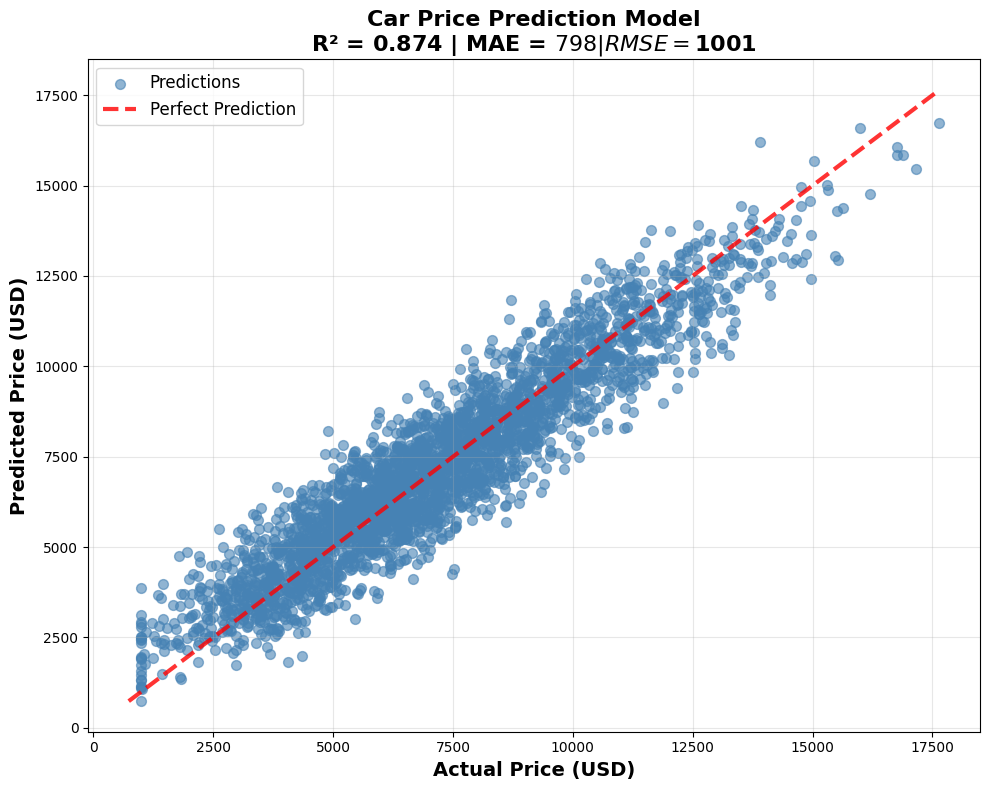

In [110]:
simple_plot = plot_simple_comparison(y_test, y_pred, "Car Price Prediction Model")


In [111]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R² Score"],
    "Value": [f"${mae:,.2f}", f"${rmse:,.2f}", f"{r2:.3f}"]
})

print(metrics_df.to_string(index=False))

  Metric     Value
     MAE   $797.75
    RMSE $1,000.76
R² Score     0.874


In [112]:
df["price_usd"].describe()

count    10000.000000
mean      7179.754532
std       2795.270940
min       1000.000000
25%       5176.547500
50%       6961.260000
75%       8993.732500
max      17647.630000
Name: price_usd, dtype: float64

## First Conclusion

R2 > 0.85 is tipically a sign of good generalization; we are not in an overfitting scenario.
MAE and RMSE are okay-ish compared to the average price, so it's a decent result. Not perfect, as a customer could end up paying close to
1000$ more than what they should.

# Tuning

In [113]:
model = Sequential()
model.add(Dense(128, input_shape=(input_dim,), activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.005), loss="mse", metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])

c:\Users\Utente\Documents\PythonV\venv_310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
n_epochs = 30

history = model.fit(X_train, y_train,
          epochs=n_epochs,
          batch_size=256,
          validation_split=0.3)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 59269520.0000 - mean_absolute_error: 7172.4580 - root_mean_squared_error: 7698.5610 - val_loss: 59114560.0000 - val_mean_absolute_error: 7181.0781 - val_root_mean_squared_error: 7688.5991
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 54919876.0000 - mean_absolute_error: 6869.3779 - root_mean_squared_error: 7407.4912 - val_loss: 34338696.0000 - val_mean_absolute_error: 5317.2793 - val_root_mean_squared_error: 5859.9229
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21039178.0000 - mean_absolute_error: 3830.7949 - root_mean_squared_error: 4528.5400 - val_loss: 5491145.5000 - val_mean_absolute_error: 2051.5923 - val_root_mean_squared_error: 2343.3193
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3939525.7500 - mean_absolute_error: 1661.8889 - root_mean_squared_error: 1971.2588 - val_loss: 2173544.5000 - val_mean_absolute_error: 1125.2606 - val_root_mean_squared_error: 1474.2946
Epoch 5/30
20/20 ━

In [115]:
y_pred = model.predict(X_test.values.astype(np.float32))


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


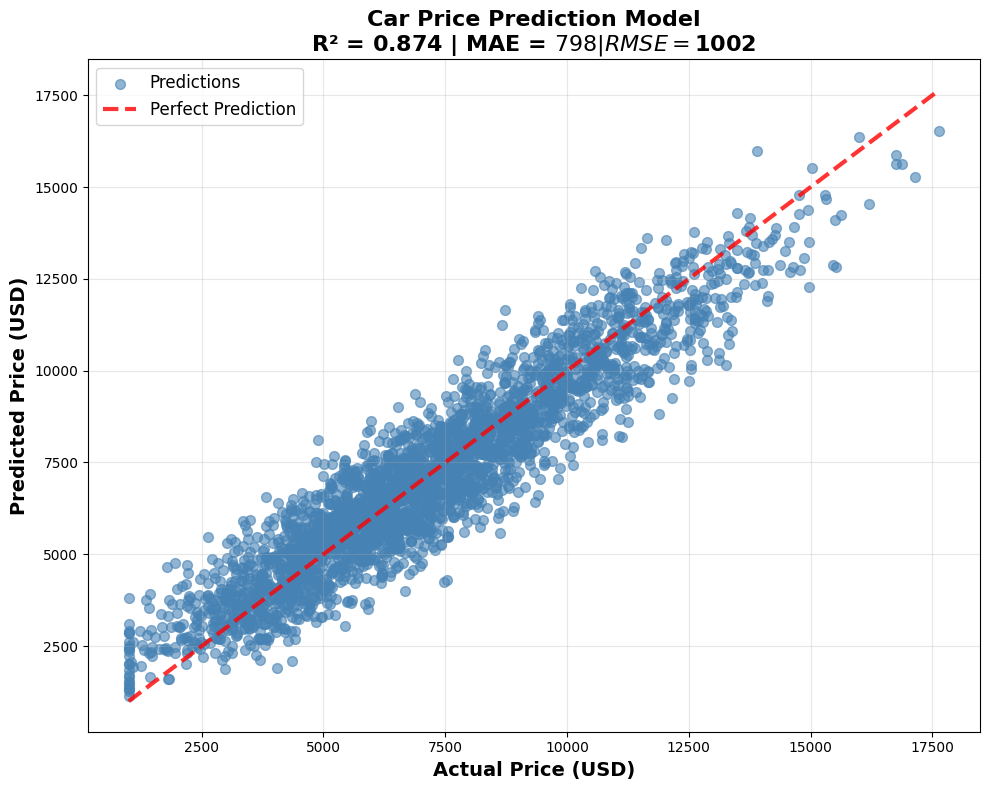

In [116]:
simple_plot = plot_simple_comparison(y_test, y_pred, "Car Price Prediction Model")

In [117]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R² Score"],
    "Value": [f"${mae:,.2f}", f"${rmse:,.2f}", f"{r2:.3f}"]
})

print(metrics_df.to_string(index=False))

  Metric     Value
     MAE   $797.83
    RMSE $1,001.62
R² Score     0.874


# Conclusion

Even by engineering the feature and tuning the model, the results never deviate too much from the 800$ range of error. It's not bad, is it's just 10% of the average price, but it's still not perfect. The R2 is good enough to suggest that the model is generalizing well enough, and it's not in overfitting. 

Seeing the nature of the dataset, it's possibile to obtain slightly better results with a well trained ML model rather than a NN, however, by testing, they never change that much anyway. So the "fault" lies in the dataset and the features.